## 🧱 0. Setup & Imports

### 🔧 Colab Bootstrap for the Project

In [ ]:
# Add path just for first import
from src.utils.colab_helper import bootstrap_colab

bootstrap_colab(
    repo_url="https://github.com/Teshager21/insurance-risk-modeling.git",
    repo_name="insurance-risk-modeling",
    requirements_file="requirements.txt",
    dvc_remote_type="gdrive",  # or s3, gs, etc.
    marker_file=".dvc/config"  # or pyproject.toml
)

### 🧪 5. Add Source Directory to Path

In [ ]:
import sys
sys.path.append('/content/' + REPO_NAME + '/src')

# Test import
# from your_package.module import YourClass


In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import sweetviz
import geopandas as gpd
from autoviz import AutoViz_Class
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from features.risk_model_pipeline import ModelPipelineOptuna

/home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [4]:
#suppress warning errors
warnings.filterwarnings("ignore")
#load enviroment variables
load_dotenv()

True

In [5]:
# Automatically go to project root (where .git or README.md is)
project_root = Path.cwd()
while not (project_root / "README.md").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Project root set to:", project_root)


Project root set to: /home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling


## 🔁 Step 1: Look at the Big Picture

### Framing the problem,Business Objective,Current Solution,Machine Learning Task & Assumptions:

| Element                | Description                                                               |
| ---------------------- | ------------------------------------------------------------------------- |
| **Business Objective** | Predict risk & set optimal premiums                                       |
| **Current Solution**   | Flat-rate pricing based on limited heuristics                             |
| **ML Tasks**           | Regression (severity), classification (probability), regression (premium) |
| **Assumptions**        | Data is representative, features correlate with claim behavior, etc.      |


## 📦 Step 2: Load the Data

In [6]:
# Load the insurance data
processed_data_dir=os.getenv("PROCESSED_DATA")
file_path= os.path.join(processed_data_dir,'cleaned_insurance_data.parquet')
df=pd.read_parquet(file_path)
df.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Bank,AccountType,MaritalStatus,Province,PostalCode,MainCrestaZone,SubCrestaZone,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,WrittenOff,Rebuilt,Converted,CrossBorder,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,TotalPremium,TotalClaims,Gender_Inferred,make_model,province_postal,cresta_zone_full,cover_package,vehicle_class,vehicle_fin_status,vehicle_age_years,vehicle_age_from_reg,premium_to_sum_ratio,claims_to_premium_ratio
0,145249,12827.0,2015-03-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Windscreen_Windscreen_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,12.8,11.0,2192.982456,0.0
1,145249,12827.0,2015-05-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Windscreen_Windscreen_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,12.9,11.0,2192.982456,0.0
2,145249,12827.0,2015-07-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,0.01,Monthly,25.00000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Windscreen_Windscreen_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,13.1,11.0,0.000000,0.0
3,145255,12827.0,2015-05-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,119300.00,Monthly,220.16145,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,54.824561,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Own damage_Own Damage_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,12.9,11.0,0.000460,0.0
4,145255,12827.0,2015-07-01,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,Gauteng,1459,Rand East,Rand East,60054685.5,Passenger Vehicle,2004.0,MERCEDES-BENZ,E 240,4.0,2597.0,130.0,S/D,4.0,2002-06-01,Yes,No,119300.0,More than 6 months,Unknown,Unknown,Unknown,Unknown,119300.00,Monthly,220.16145,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male,MERCEDES-BENZ_E 240,Gauteng_1459,Rand East_Rand East,Own damage_Own Damage_Comprehensive - Taxi,Passenger Vehicle_S/D_4.0,119300.0_More than 6 months_Unknown,13.1,11.0,0.000000,0.0


## 📊 Step 3: Explore the Data

#### Sweetviz

In [7]:
df.columns.sort_values
len(df.columns)

55

## Step 4 Discover and Visualize the Data to Gain Insights

In [34]:
# report = sweetviz.analyze(df)
# report.show_html("reports/insurance_sweetviz.html")

## Claim Severity

#### Only those records with Claims

In [8]:
df_with_claims=df[df['TotalClaims']>0]   # drop rows with no claim
df_with_claims.shape

(2775, 55)

##### Drop unique Identifiers -> they don't have any predictive value

In [9]:
for col in df.columns.to_list():
     if df[col].is_unique == True:
          print(f"{col} : {df[col].is_unique}")

In [10]:
duc=df.nunique()
duc[duc<10].sort_values(ascending=False)

Province            9
LegalType           6
Title               5
VehicleType         5
Section             5
AccountType         4
MaritalStatus       4
Product             4
Citizenship         4
NewVehicle          3
WrittenOff          3
Rebuilt             3
Converted           3
IsVATRegistered     2
CrossBorder         2
TermFrequency       2
AlarmImmobiliser    2
TrackingDevice      2
Gender_Inferred     2
NumberOfDoors       1
Cylinders           1
dtype: int64

### Feature Scaling:

In [25]:
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank',
       'AccountType', 'MaritalStatus', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'TotalPremium', 'TotalClaims', 'Gender_Inferred',
       'make_model', 'province_postal', 'cresta_zone_full', 'cover_package',
       'vehicle_class', 'vehicle_fin_status', 'vehicle_age_years',
       'vehicle_age_from_reg', 'premium_to_sum_ratio',
       'claims_to_premium_ratio'],
   

In [27]:
df_with_claims.isnull().sum().sort_values(ascending=False)

UnderwrittenCoverID         0
Product                     0
Rebuilt                     0
Converted                   0
CrossBorder                 0
SumInsured                  0
TermFrequency               0
CalculatedPremiumPerTerm    0
ExcessSelected              0
CoverCategory               0
CoverType                   0
CoverGroup                  0
Section                     0
TotalPremium                0
NewVehicle                  0
TotalClaims                 0
Gender_Inferred             0
make_model                  0
province_postal             0
cresta_zone_full            0
cover_package               0
vehicle_class               0
vehicle_fin_status          0
vehicle_age_years           0
vehicle_age_from_reg        0
premium_to_sum_ratio        0
WrittenOff                  0
CapitalOutstanding          0
PolicyID                    0
SubCrestaZone               0
TransactionMonth            0
IsVATRegistered             0
Citizenship                 0
LegalType 

In [28]:
# For Ridge (default)
model_ridge = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims')
results_ridge = model_ridge.train_and_evaluate()

[I 2025-06-17 17:58:18,917] A new study created in memory with name: no-name-05336b45-3a2f-4f5c-abe0-3eca7db87f4a
INFO:features.risk_model_pipeline:Trial params {'alpha': 0.1940979961747446} got CV RMSE=6588.4402
[I 2025-06-17 17:58:24,370] Trial 0 finished with value: 6588.440166040467 and parameters: {'alpha': 0.1940979961747446}. Best is trial 0 with value: 6588.440166040467.
INFO:features.risk_model_pipeline:Best params found: {'alpha': 0.1940979961747446}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=8270.0897, R2=0.9520


[I 2025-06-17 17:59:23,629] A new study created in memory with name: no-name-41c33a8d-3c48-4bc9-a7b3-797ea1d64839


INFO:features.risk_model_pipeline:Trial params {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 7} got CV RMSE=7813.4531
[I 2025-06-17 17:59:29,859] Trial 0 finished with value: 7813.453139821914 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 7813.453139821914.
INFO:features.risk_model_pipeline:Best params found: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 7}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9228.7051, R2=0.9402
INFO:features.risk_model_pipeline:Generating SHAP explanations...


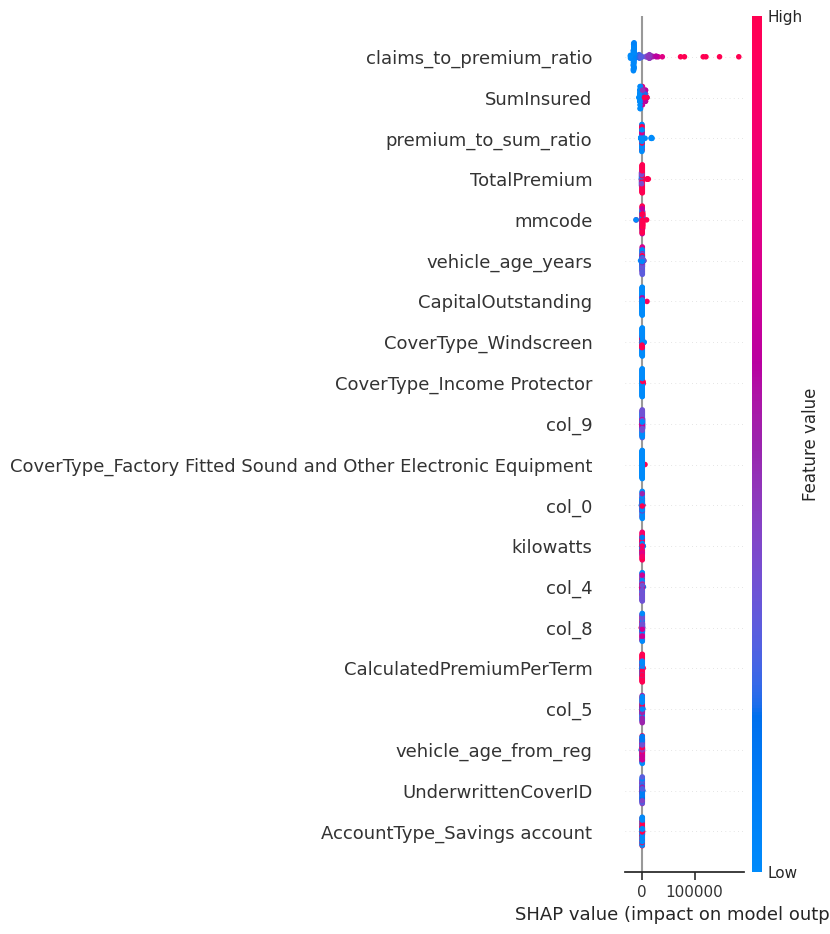

In [29]:
# For Decision Tree
model_dt = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='decision_tree')
results_dt = model_dt.train_and_evaluate()

In [ ]:
# For Random Forest
model_rf = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='random_forest')
results_rf = model_rf.train_and_evaluate()

## 🔧 Step 5: Select a Model and Train

In [16]:
# For XGBoost
model_xgb = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='xgboost')
results_xgb = model_xgb.train_and_evaluate()

[I 2025-06-17 16:15:08,049] A new study created in memory with name: no-name-31f506d2-fca9-455e-a1ae-11148e753063
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.048870623608190104, 'subsample': 0.7398841711557423} got CV RMSE=5767.1476
[I 2025-06-17 16:15:14,786] Trial 0 finished with value: 5767.147606011301 and parameters: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.048870623608190104, 'subsample': 0.7398841711557423}. Best is trial 0 with value: 5767.147606011301.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.048870623608190104, 'subsample': 0.7398841711557423}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9004.3145, R2=0.9431
INFO:features.risk_model_pipeline:Generating SHAP explanations...


### Baseline models:

### Training on a Small Set (for initial sanity check):

### Better Evaluation Using Cross-Validation:

### Evaluate on the Training Set:

[I 2025-06-17 18:02:40,124] A new study created in memory with name: no-name-87d5432f-e7f7-46c2-a4af-9ae4df500dbd
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 69, 'max_depth': 12, 'learning_rate': 0.053227787529279105, 'subsample': 0.6928100999501277} got CV RMSE=6566.7671
[I 2025-06-17 18:02:50,533] Trial 0 finished with value: 6566.767095749512 and parameters: {'n_estimators': 69, 'max_depth': 12, 'learning_rate': 0.053227787529279105, 'subsample': 0.6928100999501277}. Best is trial 0 with value: 6566.767095749512.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 69, 'max_depth': 12, 'learning_rate': 0.053227787529279105, 'subsample': 0.6928100999501277}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=8892.9216, R2=0.9445
INFO:features.risk_model_pipeline:Generating SHAP explanations...


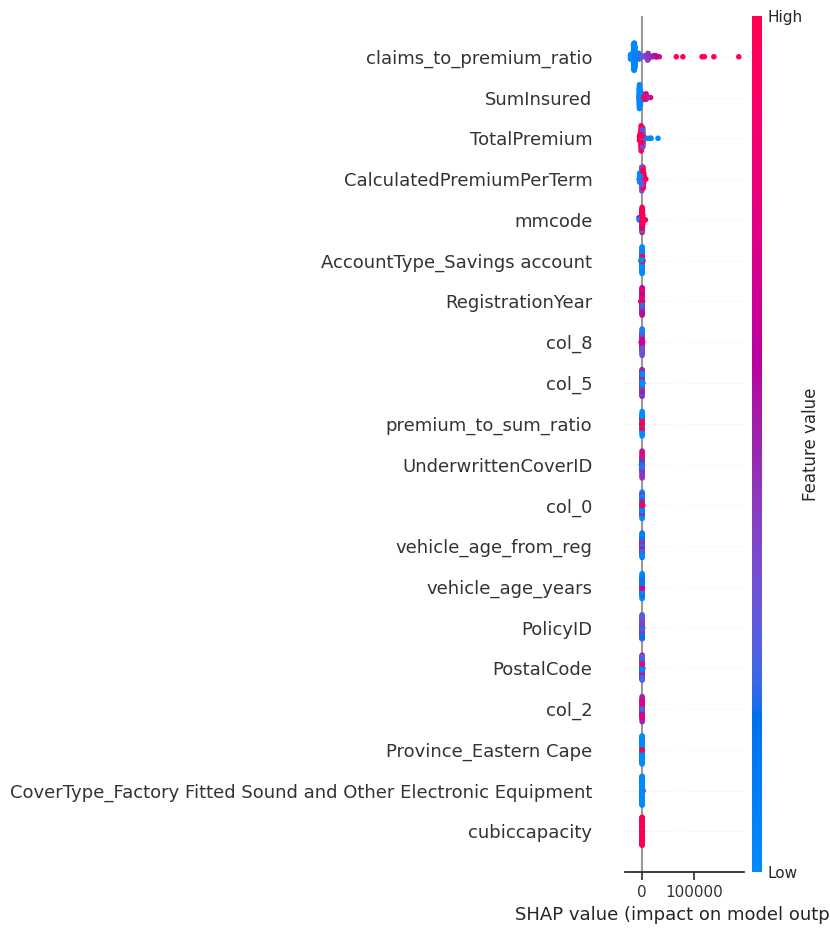

In [38]:

pipeline = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='xgboost')
pipeline.tune_hyperparameters() 
results = pipeline.train_and_evaluate()
# generate_training_report(results, pipeline.model_type)

In [ ]:
pipeline.


# 🧠 Model Training Report — XGBOOST

## 📌 Summary

- **Model**: `xgboost`
- **RMSE on Test Set**: `9004.3145`
- **R² Score**: `0.9431`
- **Best Hyperparameters (via Optuna)**:
  - `n_estimators`: `85`
  - `max_depth`: `13`
  - `learning_rate`: `0.03520370770940197`
  - `subsample`: `0.8828523280159433`

---

## 📈 Residual Analysis


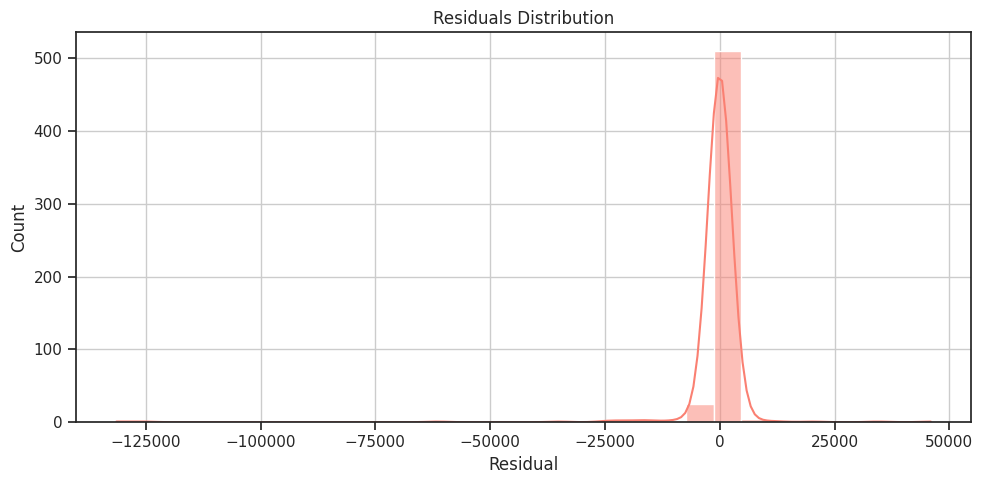


---

## 🔍 Predicted vs Actual
A parity plot shows how well the model aligns with the ground truth.


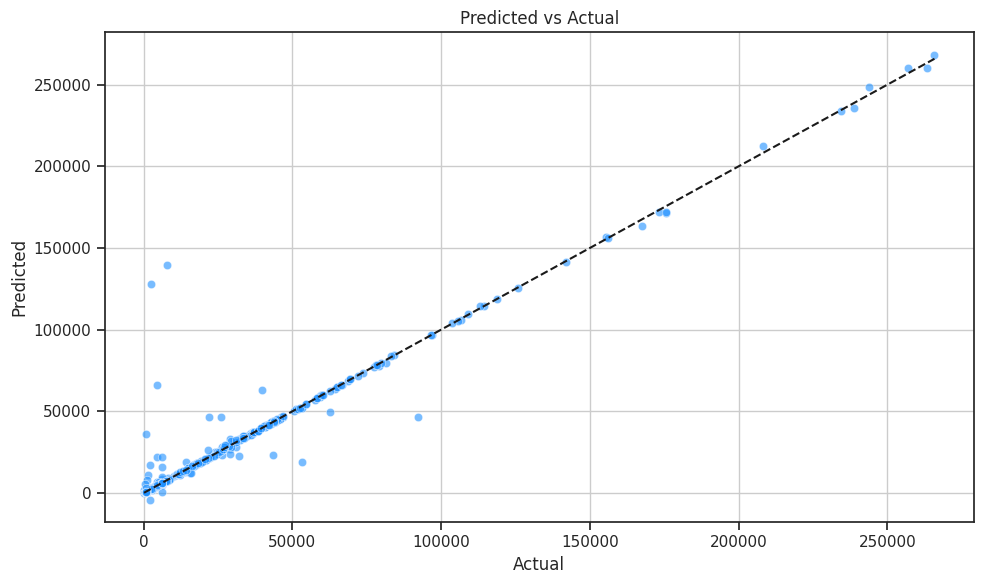


---

## ✅ Conclusion

- The model demonstrates robust generalization
    with **RMSE = 9004.31** and **R² = 0.94**.
- Optuna hyperparameter tuning improved performance.
- Consider SHAP or LIME for further interpretation.

---
*Generated with 💡 by `ModelPipelineOptuna`.*



---

## 🧬 SHAP Summary Plot

Provides insights into feature contributions.


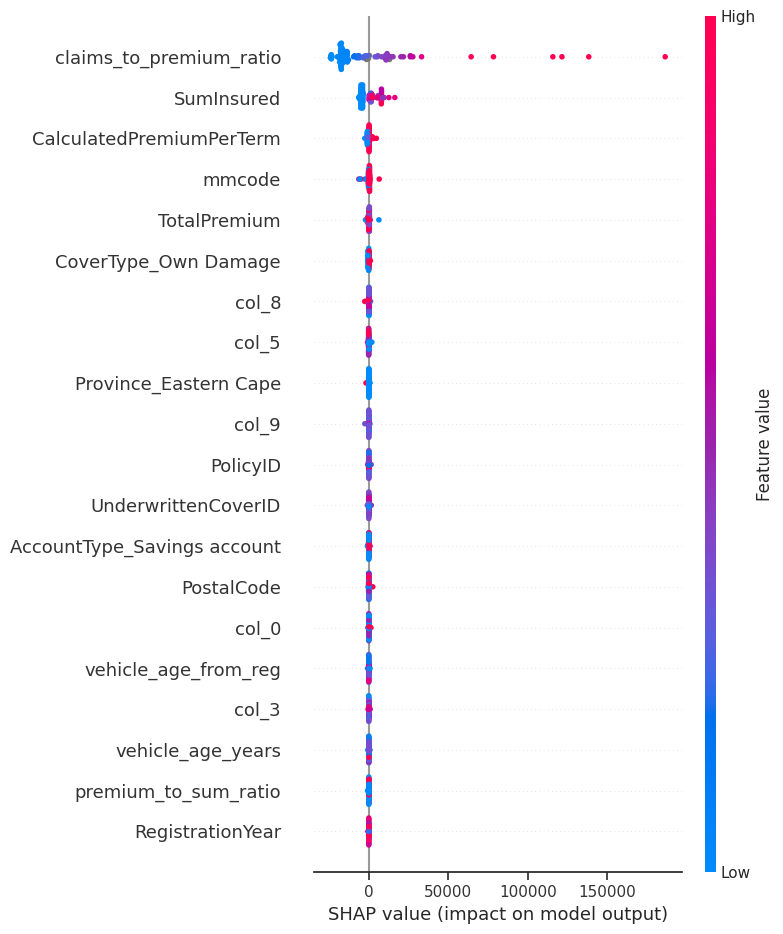

In [44]:
pipeline.generate_training_report(results, pipeline.model_type)

### ✅ Keep These (High Impact Features)

The top features have the widest horizontal spread (i.e., high SHAP value magnitudes), indicating they greatly influence the model’s output:

    SumInsured – Strongest influence, consistently high SHAP impact.

    CalculatedPremiumPerTerm

    TotalPremium

    CapitalOutstanding

These are financially related features and likely dominate the prediction of TotalClaims.

### ⚠️ Candidate for Dropping or Investigating Further

These features are at the bottom of the plot and show very low SHAP value magnitude, suggesting they have little to no impact:

    SubCrestaZone_Cape Mid West

    TransactionMonth_2015-07-01 00:00:00

    AccountType_Transmission account

    SubCrestaZone_Transvaal North West

    bodytype_S/D

    col_9 – (suspiciously generic; might be a placeholder or badly named column)

#### ⚖️ Mid-Level (Optional Tuning)

These features are in the middle section, with moderate importance:

    PostalCode

    mmcode

    UnderwrittenCoverID

    cubiccapacity

    TransactionMonth_* (may be collinear or sparse)

In [40]:
results['y_pred']

array([ 8.07659424e+02,  3.47415698e+03,  4.22595195e+04,  2.46537134e+03,
        1.81149258e+04,  4.38847734e+04,  6.48554346e+03,  1.53091406e+03,
        1.30298950e+03,  1.44861621e+03,  2.84021816e+04,  1.07479871e+03,
        1.51302041e+04,  5.07778086e+04,  9.82163086e+03,  1.35431714e+03,
        1.05896422e+05,  9.79914062e+02,  2.07750586e+03,  2.17551738e+04,
        3.47415698e+03,  3.98221436e+03,  6.02145508e+03,  1.11520801e+03,
        1.37659485e+03,  2.07400762e+04,  5.49591504e+03,  2.16653750e+04,
        4.38568242e+04,  6.49342500e+04,  1.63223062e+05,  5.13966797e+03,
        3.58665771e+03,  1.14177161e+03,  7.70315674e+02,  2.66994199e+04,
        2.65393828e+04,  1.70365449e+04,  2.64526895e+04,  7.90623901e+02,
        6.10578711e+03,  1.50779688e+03,  2.05335020e+04,  2.06170527e+04,
        2.61413666e+02,  6.17944482e+03,  3.67821594e+02,  6.16993262e+03,
        6.13418408e+03,  1.25259753e+03,  2.53802344e+04,  5.35410400e+03,
        4.19020355e+02,  

In [45]:
# Preview features to drop
shap_summary = pipeline.filter_low_shap_features(threshold=0.01, drop=False)
display(shap_summary)

INFO:features.risk_model_pipeline:Filtering features based on SHAP values...


,feature,mean_abs_shap,importance_fraction
0,claims_to_premium_ratio,20449.870149,0.724029
1,SumInsured,4461.871972,0.157973
2,CalculatedPremiumPerTerm,790.715589,0.027995
3,mmcode,534.738390,0.018932
4,TotalPremium,386.343707,0.013679
5,CoverType_Own Damage,218.014040,0.007719
6,col_8,137.348966,0.004863
7,col_5,130.805116,0.004631
8,Province_Eastern Cape,103.873203,0.003678
9,col_9,96.167907,0.003405


In [46]:

# Actually drop them
pipeline.filter_low_shap_features(threshold=0.01, drop=True);

INFO:features.risk_model_pipeline:Filtering features based on SHAP values...


In [47]:
len(df_with_claims.columns)

55

In [48]:
pipeline.dropped_features_ 

['CoverType_Own Damage',
 'col_8',
 'col_5',
 'Province_Eastern Cape',
 'col_9',
 'PolicyID',
 'UnderwrittenCoverID',
 'AccountType_Savings account',
 'PostalCode',
 'col_0',
 'vehicle_age_from_reg',
 'col_3',
 'vehicle_age_years',
 'premium_to_sum_ratio',
 'RegistrationYear',
 'CoverType_Factory Fitted Sound and Other Electronic Equipment',
 'col_1',
 'col_7',
 'Province_KwaZulu-Natal',
 'col_4',
 'CoverType_Income Protector',
 'CapitalOutstanding',
 'col_2',
 'AccountType_Current account',
 'cubiccapacity',
 'CoverGroup_Comprehensive - Taxi',
 'Gender_Inferred_Female',
 'bodytype_S/D',
 'col_6',
 'Province_Gauteng',
 'kilowatts',
 'NewVehicle_More than 6 months',
 'Province_Limpopo',
 'Product_Mobility Commercial Cover: Monthly',
 'bodytype_MPV',
 'Title_Ms',
 'Title_Mr',
 'Citizenship_  ',
 'VehicleType_Passenger Vehicle',
 'CoverType_Windscreen',
 'Province_North West',
 'Province_Western Cape',
 'TrackingDevice_No',
 'CrossBorder_Unknown',
 'TermFrequency_Monthly',
 'CoverType_Cre

In [49]:
pipeline.tune_hyperparameters()

[I 2025-06-17 16:09:17,750] A new study created in memory with name: no-name-5536182d-3e6a-4f6b-aa92-f55188aa0ff2
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.11410749404140844, 'subsample': 0.7533655796368088} got CV RMSE=6056.1266
[I 2025-06-17 16:09:33,537] Trial 0 finished with value: 6056.126632922588 and parameters: {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.11410749404140844, 'subsample': 0.7533655796368088}. Best is trial 0 with value: 6056.126632922588.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.11410749404140844, 'subsample': 0.7533655796368088}


INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9123.0208, R2=0.9416
INFO:features.risk_model_pipeline:Generating SHAP explanations...


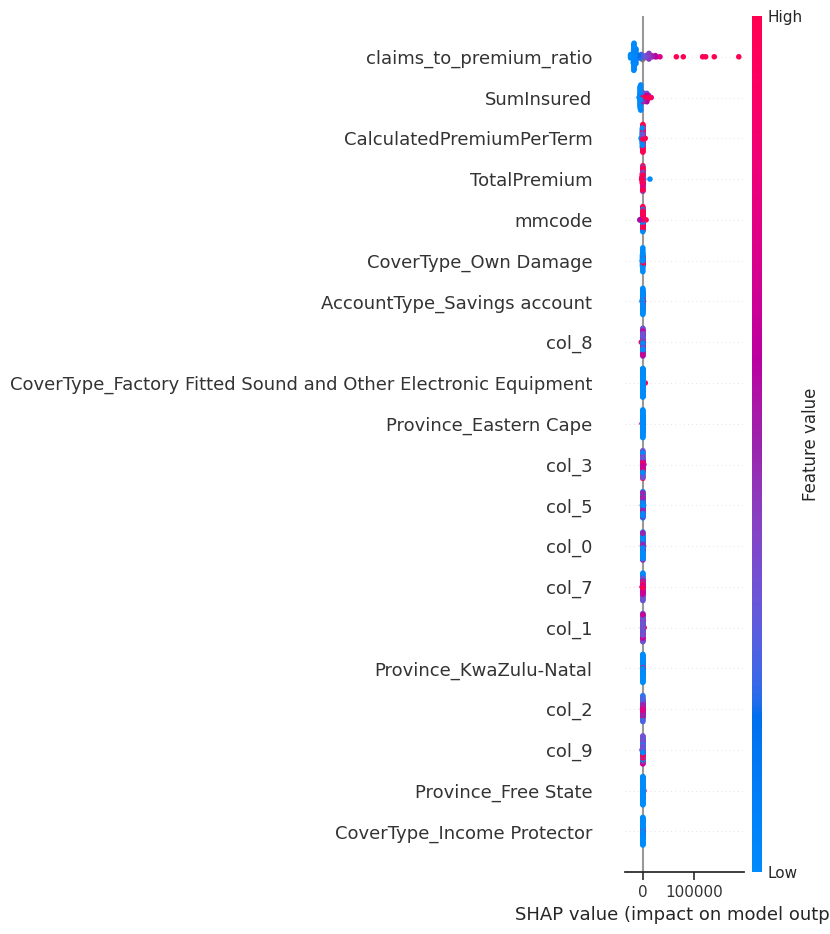

In [50]:
results = pipeline.train_and_evaluate()

In [51]:
reduced_df = pipeline.df.copy()
len(reduced_df.columns)

43

[I 2025-06-17 16:10:03,317] A new study created in memory with name: no-name-bb54e6e5-94b3-4056-9cc7-6fa782cbb2ae


INFO:features.risk_model_pipeline:Trial params {'n_estimators': 196, 'max_depth': 14, 'learning_rate': 0.010652753854280331, 'subsample': 0.6793686373373053} got CV RMSE=9205.2546
[I 2025-06-17 16:10:15,741] Trial 0 finished with value: 9205.254630808358 and parameters: {'n_estimators': 196, 'max_depth': 14, 'learning_rate': 0.010652753854280331, 'subsample': 0.6793686373373053}. Best is trial 0 with value: 9205.254630808358.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 196, 'max_depth': 14, 'learning_rate': 0.010652753854280331, 'subsample': 0.6793686373373053}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=9123.0208, R2=0.9416
INFO:features.risk_model_pipeline:Generating SHAP explanations...


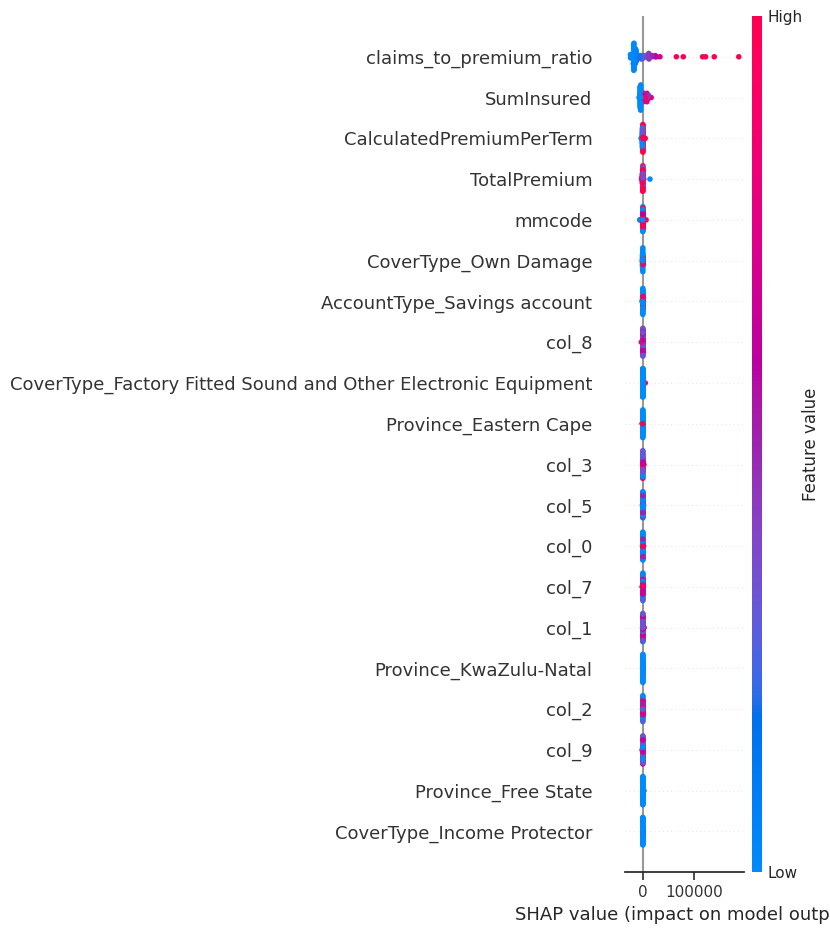

In [52]:
new_pipeline = ModelPipelineOptuna(reduced_df, target_col='TotalClaims', model_type='xgboost')
new_pipeline.tune_hyperparameters()
new_results = new_pipeline.train_and_evaluate()

In [20]:
df_with_claims.columns.sort_values()

Index(['AccountType', 'AlarmImmobiliser', 'Bank', 'CalculatedPremiumPerTerm',
       'CapitalOutstanding', 'Citizenship', 'Converted', 'CoverCategory',
       'CoverGroup', 'CoverType', 'CrossBorder', 'Cylinders', 'ExcessSelected',
       'Gender_Inferred', 'IsVATRegistered', 'LegalType', 'MainCrestaZone',
       'MaritalStatus', 'Model', 'NewVehicle', 'NumberOfDoors', 'PolicyID',
       'PostalCode', 'Product', 'Province', 'Rebuilt', 'RegistrationYear',
       'Section', 'SubCrestaZone', 'SumInsured', 'TermFrequency', 'Title',
       'TotalClaims', 'TotalPremium', 'TrackingDevice', 'TransactionMonth',
       'UnderwrittenCoverID', 'VehicleIntroDate', 'VehicleType', 'WrittenOff',
       'bodytype', 'cubiccapacity', 'kilowatts', 'make', 'mmcode'],
      dtype='object')

## 🚀 Predicted Severity

In [11]:
df['MadeClaim']= df['TotalClaims']>0

In [12]:
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank',
       'AccountType', 'MaritalStatus', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'TotalPremium', 'TotalClaims', 'Gender_Inferred',
       'make_model', 'province_postal', 'cresta_zone_full', 'cover_package',
       'vehicle_class', 'vehicle_fin_status', 'vehicle_age_years',
       'vehicle_age_from_reg', 'premium_to_sum_ratio',
       'claims_to_premium_ratio', 'Mad

In [13]:
model = ModelPipelineOptuna(df, target_col="TotalClaims")
df_with_prob = model.train_claim_probability_model(
    feature_cols=["NewVehicle","bodytype","vehicle_age_from_reg","Province","SumInsured", "TotalPremium"],
    target_col="MadeClaim"
)


[Claim Prob] ROC-AUC: 0.9116
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    199354
        True       0.00      0.00      0.00       555

    accuracy                           1.00    199909
   macro avg       0.50      0.50      0.50    199909
weighted avg       0.99      1.00      1.00    199909



In [14]:
pipeline = ModelPipelineOptuna(df_with_claims, target_col='TotalClaims', model_type='xgboost')
pipeline.tune_hyperparameters() 
results = pipeline.train_and_evaluate()

[I 2025-06-17 18:26:43,962] A new study created in memory with name: no-name-c409a864-2bbf-4045-a87f-6d572f894591
INFO:features.risk_model_pipeline:Trial params {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.021584397562311678, 'subsample': 0.6808261988879436} got CV RMSE=6074.6629
[I 2025-06-17 18:26:54,872] Trial 0 finished with value: 6074.662893632646 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.021584397562311678, 'subsample': 0.6808261988879436}. Best is trial 0 with value: 6074.662893632646.
INFO:features.risk_model_pipeline:Best params found: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.021584397562311678, 'subsample': 0.6808261988879436}
INFO:features.risk_model_pipeline:Final evaluation on test set: RMSE=8892.9216, R2=0.9445
INFO:features.risk_model_pipeline:Generating SHAP explanations...


In [ ]:
pipeline = ModelPipelineOptuna(df, target_col='TotalClaims', model_type='xgboost')
pipeline.tune_hyperparameters() 
results = pipeline.train_and_evaluate()

In [ ]:
df = model.train_claim_probability_model(feature_cols=['SumInsured', 'TotalPremium'], target_col='MadeClaim')
df['predicted_severity'] = results['y_pred']  # Ensure this is populated by your regression pipeline
df = model.calculate_risk_based_premium()

#### Save the Model

In [9]:


# Save the trained model
pipeline.save_model("src/models/trained_insurance_model.joblib")

INFO:features.risk_model_pipeline:Model pipeline saved to: src/models/trained_insurance_model.joblib
